<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Reference Link Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting the quality of Reference links provided in Q&A answers,
- to provide an experimental framework for users to iterate and improve on the default classification template.



# Reference Links in Q&A

In only chatbots and Q&A systems, many times reference links are provided to along with an answer to help point users to documentation or pages that contain more information or the source for the answer.

EXAMPLE:
Q&A from Arize-Phoenix Documentation

**QUESTION**:
Does Phoenix Evals support models besides OpenAI for running Evals?

**ANSWER**:
Phoenix does support a large set of LLM models through the model object. Phoenix supports OpenAI (GPT-4, GPT-4-32k, GPT-3.5 Turbo, GPT-3.5 Instruct, etc...), Azure OpenAI, Google Palm2 Text Bison, and All AWS Bedrock models (Claude, Mistral, etc...).

**REFERENCE LINK**:
https://docs.arize.com/phoenix/api/evaluation-models

This Eval checks the reference link returned answers the question asked in a coversation


In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 180

# If you want to provide URLs and have this notebook download the page text
# The default test dataset already has the downloaded text data
DOWNLOAD_TEXT_FROM_URL = False

## Install Dependencies and Import Libraries

In [2]:
!pip install -qq "arize-phoenix[experimental,llama-index]" ipython matplotlib "openai>1" pycm scikit-learn tiktoken playwright nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
import phoenix as px
from phoenix.experimental.evals import OpenAIModel, llm_classify
from phoenix.experimental.evals.templates import (
    REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP,
    REFERENCE_LINK_CORRECTNESS_PROMPT_TEMPLATE,
)
from phoenix.trace.exporter import HttpExporter
from phoenix.trace.openai import OpenAIInstrumentor
from phoenix.trace.tracer import Tracer
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

In [5]:
session = px.launch_app()
tracer = Tracer(exporter=HttpExporter())
OpenAIInstrumentor(tracer).instrument()

🌍 To view the Phoenix app in your browser, visit http://127.0.0.1:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


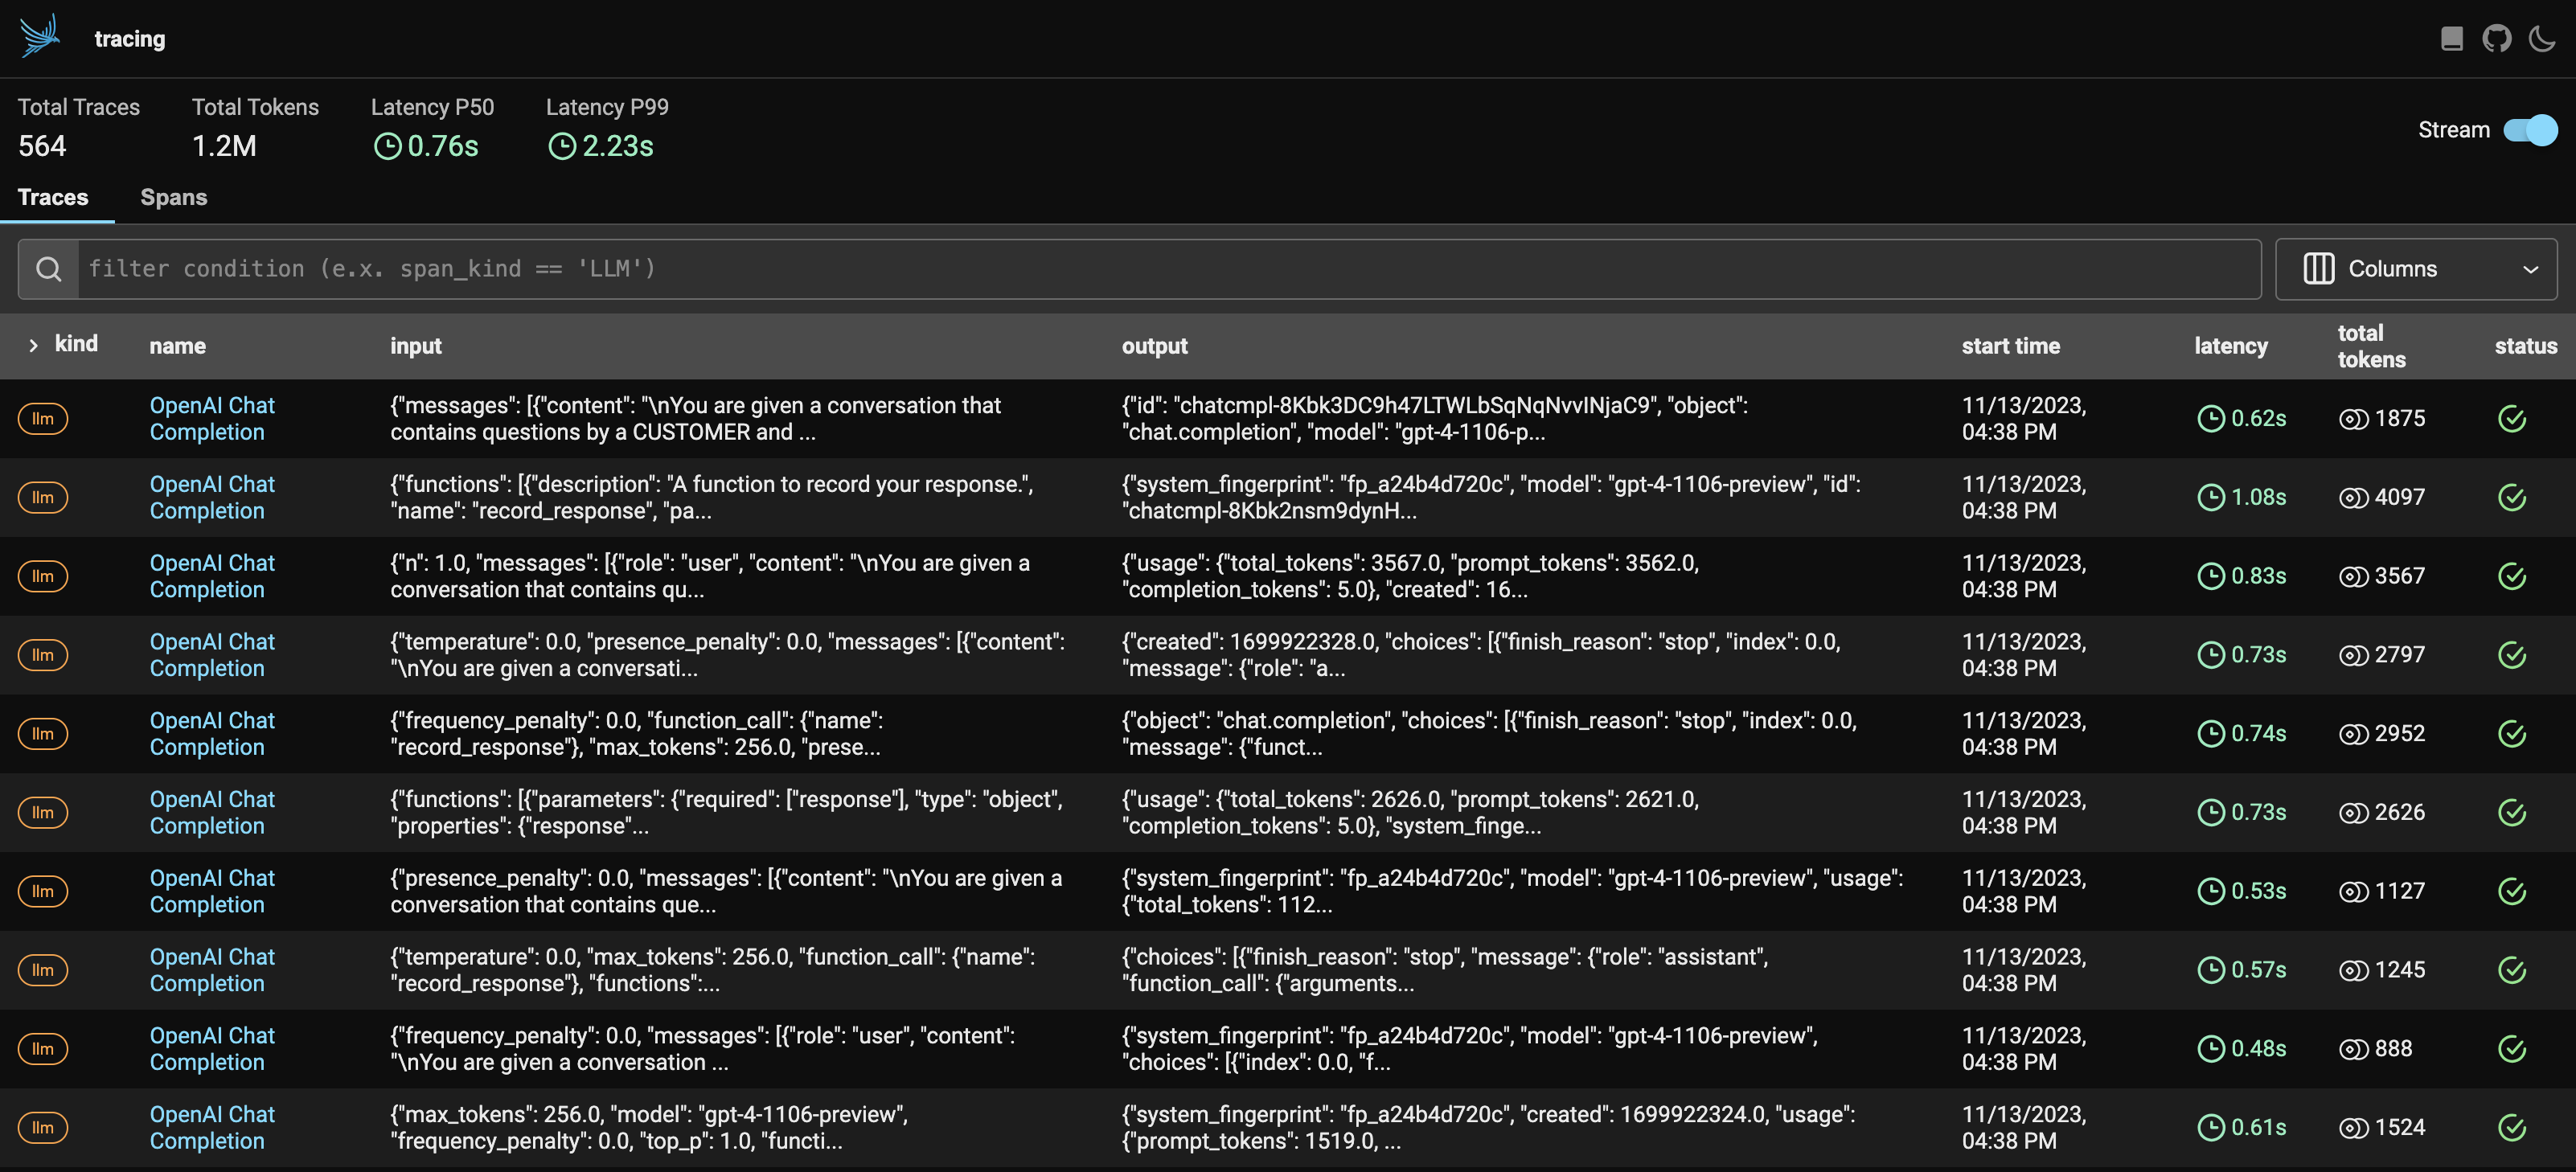

Visualize your evals using Phoenix, click link above to open local phoenix session

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and ground truth. This dataset was created based on questions and answers on the Arize documentation. There are answers with correct reference links and others with wrong reference links.


In [6]:
df = (
    pd.read_csv(
        "https://storage.googleapis.com/arize-assets/phoenix/evals/ref-link-classification/ref_link_golden_test_data.csv",
    )
    .sample(n=N_EVAL_SAMPLE_SIZE)
    .rename(columns={"conversation": "input", "document_text": "reference"})
)
df.head(3)

Unnamed: 0                                                        input  \
18           24                   What drift metrics are supported in Arize?   
27           34             Can I deploy Arize on my own Kubernetes cluster?   
168         210  What is the definition of a model or a prediction in Arize?   

                                                                            url  \
18            https://docs.arize.com/arize/monitors/setup/choosing-your-metrics   
27   https://docs.arize.com/arize/on-premise-deployment/on-premise/installation   
168     https://docs.arize.com/arize/sending-data-guides/model-schema-reference   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [7]:
# @title Download Text HTML (optional)
# HTML Ref Link Pages
# This section is not used by default, data is preloaded in saved file
# This is used to convert URLs to text in a dataframe, this downloader
# Assumes HTML as the Ref Link webpage (not usable with JS rendered pages)
if DOWNLOAD_TEXT_FROM_URL:
    from llama_index import download_loader

    BeautifulSoupWebReader = download_loader("BeautifulSoupWebReader")
    loader = BeautifulSoupWebReader()

    def download_url_text(url):
        try:
            # Use loader.load_data from llama to download the document
            documents = loader.load_data(urls=[url])

            # Assuming documents is a list-like object with text as an attribute
            if documents and hasattr(documents[0], "text"):
                return documents[0].text
            else:
                # If documents is empty or doesn't have the text attribute
                return None
        except Exception as e:
            # General exception handling, it's better to use more specific exceptions
            print(f"Error loading document from {url}: {e}")
            return None

    # Apply the function to your dataframe to get the text for each URL
    df["reference"] = df["url"].apply(download_url_text)

## Display Binary Ref Link Eval Template

This Eval template checks for correct link based on a question or conversation, it checks whether the text from the page that the URL reference link refers, correctly answers the quesiton.

In [8]:
print(REFERENCE_LINK_CORRECTNESS_PROMPT_TEMPLATE)


You are given a conversation that contains questions by a CUSTOMER and you are
trying to determine if the documentation page shared by the ASSISTANT correctly
answers the CUSTOMERS questions. We will give you the conversation between the
customer and the ASSISTANT and the text of the documentation returned:
    [CONVERSATION AND QUESTION]:
    {input}
    ************
    [DOCUMENTATION URL TEXT]:
    {reference}
    ************
You should respond "correct" if the documentation text answers the question the
CUSTOMER had in the conversation. If the documentation roughly answers the
question even in a general way the please answer "correct". If there are
multiple questions and a single question is answered, please still answer
"correct". If the text does not answer the question in the conversation, or
doesn't contain information that would allow you to answer the specific question
please answer "incorrect".



Template variables:
- **input** : The customer and assistant conversation, where the assistants supplies a link to answer the customers question
- **reference** : The content of the text from the page that was supplied in the link


## Configure the LLM

Configure your OpenAI API key.

In [9]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## LLM Evals: Reference Link Classifications GPT-4
Run reference link classifications against a subset of the data.

Instantiate the LLM and set parameters.

In [10]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [11]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [12]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP.values())
ref_link_classifications = llm_classify(
    dataframe=df,
    template=REFERENCE_LINK_CORRECTNESS_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/180 (0.0%) | ⏳ 00:00<? | ?it/s

Evaluate the predictions against human-labeled ground-truth labels.

              precision    recall  f1-score   support

     correct       0.97      0.83      0.89       115
   incorrect       0.76      0.95      0.84        65

    accuracy                           0.87       180
   macro avg       0.86      0.89      0.87       180
weighted avg       0.89      0.87      0.87       180



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

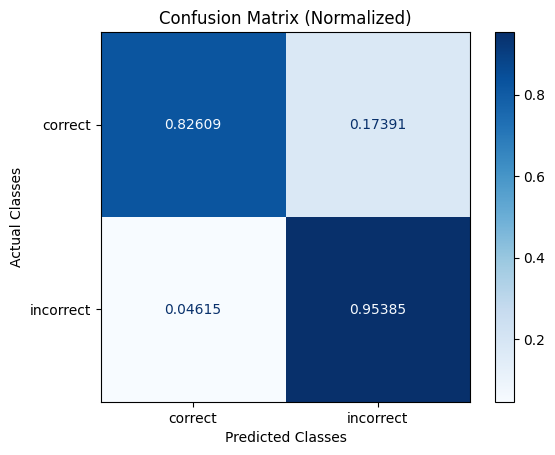

In [13]:
true_labels = df["is_correct_ref_link"].map(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP).tolist()
df["true_labels"] = true_labels
df["qa_evals"] = ref_link_classifications
print(classification_report(true_labels, ref_link_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=list(ref_link_classifications),
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## LLM Evals: Reference Link Classifications GPT-3.5

Run reference link evaluations against a subset of the data.

In [14]:
model = OpenAIModel(model_name="gpt-3.5-turbo-16k", temperature=0.0, request_timeout=20)

In [15]:
rails = list(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP.values())
ref_link_classifications = llm_classify(
    dataframe=df,
    template=REFERENCE_LINK_CORRECTNESS_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/180 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

     correct       0.86      0.54      0.66       115
   incorrect       0.51      0.85      0.64        65

    accuracy                           0.65       180
   macro avg       0.69      0.69      0.65       180
weighted avg       0.73      0.65      0.65       180



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

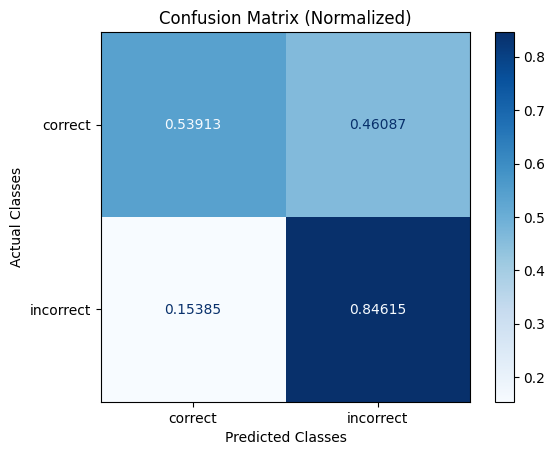

In [16]:
true_labels = df["is_correct_ref_link"].map(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, ref_link_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=ref_link_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## LLM Evals: Ref Link Evaluations GPT-4 Turbo
Run evaluations of the reference link against the data

In [17]:
model = OpenAIModel(model_name="gpt-4-1106-preview", temperature=0.0)

In [18]:
rails = list(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP.values())
ref_link_classifications = llm_classify(
    dataframe=df,
    template=REFERENCE_LINK_CORRECTNESS_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/180 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

     correct       0.95      0.70      0.80       115
   incorrect       0.64      0.94      0.76        65

    accuracy                           0.78       180
   macro avg       0.79      0.82      0.78       180
weighted avg       0.84      0.78      0.79       180



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

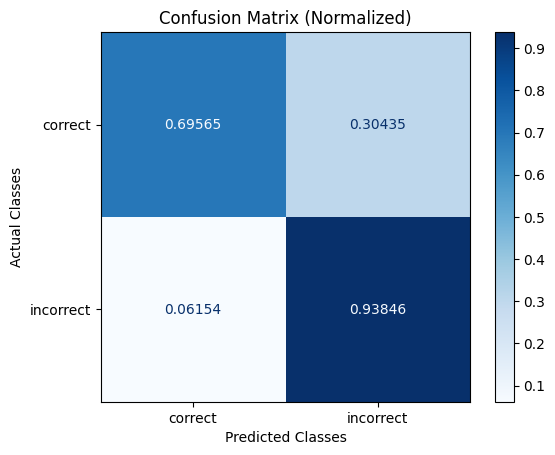

In [19]:
true_labels = df["is_correct_ref_link"].map(REFERENCE_LINK_CORRECTNESS_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, ref_link_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=ref_link_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)